In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from keras import models, optimizers, backend
from keras.layers import core, convolutional, pooling, InputLayer, Input
from sklearn import model_selection
import cv2
import random
from tensorflow import keras

from tensorflow.keras.utils import Sequence
import matplotlib.image as mpimg

import json
import matplotlib.pyplot as plt

from PIL import Image
import skimage 
from skimage.transform import resize

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from lime import lime_image

from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions




In [2]:
dataset = ('C:/Users/Ketan/Thesis/self-driving-car/challenges/resized_dataset_udacity_320x240')

In [3]:
# Read the data
df = pd.io.parsers.read_csv(os.path.join(dataset, 'out.csv'))
# # Split data into training and validation sets
df_train, df_val = model_selection.train_test_split(df, test_size=.2)


In [5]:
datagen=ImageDataGenerator(rescale=1./255, horizontal_flip=True )


In [6]:
train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=dataset, x_col="File", y_col="angle", 
                                            class_mode="raw", target_size=(240, 320), batch_size=32)

Found 4491 validated image filenames.


In [7]:
val_generator=datagen.flow_from_dataframe(dataframe=df_val, directory=dataset, x_col="File", y_col="angle", 
                                            class_mode="raw", target_size=(240, 320), batch_size=32)

Found 1123 validated image filenames.


In [8]:
inputs = Input(shape=(240, 320, 3))

In [9]:
from tensorflow.keras.applications import ResNet50


In [10]:
base_model = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet", input_shape = (240,320,3))

In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 120, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 120, 160, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
fc1 = core.Dense(512, activation='relu', name='dense_1', kernel_regularizer= keras.regularizers.L2(l2=1e-3))
fc2 = core.Dense(256, activation='relu', name='dense_2', kernel_regularizer= keras.regularizers.L2(l2=1e-3))
fc3 = core.Dense(64, activation='relu', name='dense_3', kernel_regularizer= keras.regularizers.L2(l2=1e-3))
prediction = core.Dense(1,name='output')

In [14]:
conv5_block3_out = base_model.get_layer('conv5_block3_out')
glob_avg_pooling = pooling.GlobalAveragePooling2D()
dropout = core.Dropout(.5)
x = glob_avg_pooling(conv5_block3_out.output)
x = fc1(x)
x = fc2(x)
x = fc3(x)
x = prediction(x)

model1 = tf.keras.models.Model(inputs = inputs, outputs = x)

In [15]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 120, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 120, 160, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), loss='mse',  metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [66]:
from keras.utils.vis_utils import plot_model


In [68]:
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [17]:
# model = models.Sequential()
# # model.add(Input(shape=(240,320))),
# model.add(base_model)
# model.add(pooling.GlobalAveragePooling2D())
# model.add(core.Dense(512, activation='relu'))
# model.add(core.Dropout(.5))
# model.add(core.Dense(256, activation='relu'))
# model.add(core.Dropout(.25))
# model.add(core.Dense(64, activation='relu'))
# model.add(core.Dense(1))
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), loss='mse')

In [18]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [21]:
model1.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, callbacks=[callback])

C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
140/140 [==============================] - 227s 1s/step - loss: 1.0184 - root_mean_squared_error: 0.2159 - val_loss: 0.7771 - val_root_mean_squared_error: 0.2098
Epoch 2/30
140/140 [==============================] - 207s 1s/step - loss: 0.6244 - root_mean_squared_error: 0.2013 - val_loss: 0.5046 - val_root_mean_squared_error: 0.2050
Epoch 3/30
140/140 [==============================] - 209s 1s/step - loss: 0.4257 - root_mean_squared_error: 0.1965 - val_loss: 0.3652 - val_root_mean_squared_error: 0.2002
Epoch 4/30
140/140 [==============================] - 210s 2s/step - loss: 0.3222 - root_mean_squared_error: 0.1922 - val_loss: 0.2915 - val_root_mean_squared_error: 0.1980
Epoch 5/30
140/140 [==============================] - 212s 2s/step - loss: 0.2652 - root_mean_squared_error: 0.1878 - val_loss: 0.2482 - val_root_mean_squared_error: 0.1939
Epoch 6/30
140/140 [==============================] - 211s 2s/step - loss: 0.2316 - root_mean_squared_error: 0.1868 - val_loss: 0.2267 

In [22]:
model1.save('tl_regression_resized_udacity_v4.h5')

C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
directory = ('C:/Users/Ketan/Thesis/self-driving-car/challenges/test_datset2')

In [34]:
import systematic_crop 

In [35]:
from systematic_crop import DCMDataGenerator

In [45]:
datagen1 = DCMDataGenerator

In [52]:
train_gen = datagen1(dataframe=df_train, directory=dataset, x_col="File", y_col="angle", 
                                            class_mode="raw", target_size=(240, 320), batch_size=1)

Found 4491 validated image filenames.


In [61]:
def visualize_augmentations(data_generator: DCMDataGenerator, df: pd.DataFrame):
    """Visualizes the keras augmentations with matplotlib in 3x3 grid. This function is part of create_generators() and
    can be accessed from there.

    Parameters
    ----------
    data_generator : Iterator
        The keras data generator of your training data.
    df : pd.DataFrame
        The Pandas DataFrame containing your training data.
    """
    # super hacky way of creating a small dataframe with one image
    series = df.iloc[2]

    df_augmentation_visualization = pd.concat([series, series], axis=1).transpose()
    
    train_gen = DCMDataGenerator(dataframe=df_train, directory=dataset, x_col="File", y_col="angle", 
                                            class_mode="raw", target_size=(240, 320), batch_size=1)

    iterator_visualizations = train_gen
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
        batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
        img = batch[0]  # type: ignore
        img = img[0, :, :, :]  # remove one dimension for plotting without issues
        plt.imshow(img)
    plt.show()
    plt.close()

Found 4491 validated image filenames.


AttributeError: 'DCMDataGenerator' object has no attribute 'x'

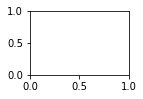

In [63]:
visualize_augmentations(train_gen, df_train)

In [23]:
def open_images(inference_folder: str) -> np.ndarray:
    """Loads images from a folder and prepare them for inferencing.

    Parameters
    ----------
    inference_folder : str
        Location of images for inferencing.

    Returns
    -------
    np.ndarray
        List of images as numpy arrays transformed to fit the efficient_net model input specs.
    """
    images = []
    for img in os.listdir(inference_folder):
        img_location = os.path.join(inference_folder, img)  # create full path to image

        with Image.open(img_location) as img:  # open image with pillow

            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  # add 0 dimension to fit input shape of efficient_net
            img = inc_net.preprocess_input(img)

        images.append(img)
    images_array = np.vstack(images)  # combine images efficiently to a numpy array
    return images_array

In [24]:
images = open_images("C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset2")


In [25]:
predictions = model1.predict_generator(images)

images_names = os.listdir("C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset2")
for image_name, prediction in zip(images_names, predictions):
    print(image_name, prediction)

C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1479425442432797491.jpg [0.46141034]
1479425442482899263.jpg [0.5057638]
1479425442532771570.jpg [0.49207637]
1479425442582809345.jpg [0.486888]
1479425442632821093.jpg [0.44952548]
1479425442682747552.jpg [0.4517351]
1479425442732806572.jpg [0.43582243]
1479425442782862182.jpg [0.44967008]
1479425442832833025.jpg [0.5350289]
1479425442882822631.jpg [0.49530065]
1479425442932809867.jpg [0.5348334]
1479425477788948138.jpg [-0.0425753]
1479425477838934577.jpg [-0.11215467]


In [100]:
import glob

In [106]:
def dummy(img_path):

    images = []
    img_path = "C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset2"
    for filename in glob.glob('C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset2/*.jpg'):
        img1 = cv2.imread(filename[2])
    return img1
    print(img1)
#         img_location = os.path.join(img_path, img)  # create full path to image
#         with cv2.imread(img_location) as img:
#             img = np.array(img)
#         images.append(img)
#     return images
            


In [107]:
dummy("C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset2")

In [90]:
import cv2

In [125]:


frameSize = (320, 240)
img_path = "C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset2"
out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, frameSize)


for filename in glob.glob('img_path/*.jpg'):
    img = cv2.imread(filename)
    img.append(img)

In [129]:
img.shape[1]

320

In [95]:
img_src = cv2.imread('C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset2/1479425574355865054.jpg')
print (img_src)

[[[ 76 114 138]
  [ 72 110 128]
  [ 77 111 124]
  ...
  [ 28  38  38]
  [ 37  49  49]
  [ 40  54  50]]

 [[ 39  81  93]
  [ 46  85  93]
  [ 70 105 108]
  ...
  [ 30  43  45]
  [ 31  47  46]
  [ 33  50  47]]

 [[ 65 105 104]
  [ 72 112 107]
  [ 73 108  98]
  ...
  [ 40  56  62]
  [ 32  49  52]
  [ 24  43  46]]

 ...

 [[255 253 255]
  [255 254 254]
  [254 255 253]
  ...
  [ 32  21  17]
  [ 32  21  17]
  [ 32  21  17]]

 [[254 253 255]
  [254 254 254]
  [254 254 254]
  ...
  [ 32  21  17]
  [ 32  21  17]
  [ 32  21  17]]

 [[254 254 254]
  [255 255 255]
  [255 255 255]
  ...
  [ 32  21  17]
  [ 32  21  17]
  [ 32  21  17]]]
